In [1]:
!nvidia-smi

Sat Mar 30 15:30:02 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   41C    P8    15W / 140W |      1MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Roberta Base Model

In [2]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import AutoTokenizer, AutoModel
from transformers import Trainer, TrainingArguments


from tqdm import tqdm


## Notebook Variables

In [3]:
# setting the model name
PRE_TRAINED_MODEL_NAME = 'roberta-base'

# setting the dataset
dataset='essays_cleaned.csv'

# setting the data path
if os.path.exists(f'/datasets/essays/{dataset}'):
    DATAPATH=f'/datasets/essays/{dataset}'
else:
    DATAPATH=f'../data/{dataset}'

# setting the checkpoint path 
if os.path.exists('ckpts'):
    CHECKPOINTPATH = 'ckpts/Persnality_trait4'
else:
    CHECKPOINTPATH = '../checkpoints/Persnality_traits4'

# training parameters
MAX_LEN = 512
TRAIN_BATCH_SIZE = 18
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 40
THRESHOLD = 0.5 # threshold for the sigmoid function

# TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setting the random seed
torch.manual_seed(17)
torch.cuda.manual_seed(17)
torch.cuda.manual_seed_all(17)
np.random.seed(17)

In [4]:
DATAPATH,CHECKPOINTPATH

('/datasets/essays/essays_cleaned.csv', 'ckpts/Persnality_trait4')

### Loading dataset

In [5]:
# loading the data
df = pd.read_csv(DATAPATH,encoding="utf-8")

In [6]:
# create a dataset class
class EssayDataset(Dataset):
    def __init__(self, df,target_list, max_len=MAX_LEN,tokenizer=tokenizer,):
        self.df = df
        self.max_len = max_len
        self.text = list(df['TEXT'])
        self.tokenizer = tokenizer
        self.targets = self.df[target_list].values
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.text[idx]
        # textRight=text
        # if(len(text)>self.max_len):
        #     textRight=textRight[:self.max_len]
        inputs1 = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt'
          
        )
    
        return {
            'text': text,
            'input_ids_roberta': inputs1['input_ids'].flatten(),
            'attention_mask_roberta': inputs1['attention_mask'].flatten(),
            'token_type_ids_roberta': inputs1['token_type_ids'].flatten(),
            'targets': torch.FloatTensor(self.targets[idx])
        }

In [7]:
# get the targets list
target_list = list(df.columns[1:])
print(f'Target list: {target_list}')
# create the datasets
dataset= EssayDataset(df,target_list)

# split data
train_size = int(0.7 * len(df))
test_size = int(0.15 * len(df))
val_size = len(df) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# create the dataloaders
train_data_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True)


Target list: ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']


In [8]:
batch=next(iter(train_data_loader))
print('Input ids shape:',batch['input_ids_roberta'].shape, 'Attention mask shape:',batch['attention_mask_roberta'].shape, 'Token type ids shape:',batch['token_type_ids_roberta'].shape, 'Targets shape:',batch['targets'].shape)
batch

Input ids shape: torch.Size([18, 512]) Attention mask shape: torch.Size([18, 512]) Token type ids shape: torch.Size([18, 512]) Targets shape: torch.Size([18, 5])


{'text': ['College is so cool I really cannot remember the last time I felt so many emotions at the same time I Have already met so many incredible and different people I cannot even begin to describe all of them I am definately having mixed thoughts about having a boyfriend at this moment because of all the new people I have met and would definately like to meet get to know and date My boyfriend is totally mad because he is so jealous I hate jealous people I wish everyone would just I do not know go along with it I ate the grosests food in jester cafeteria today and had the weirdest conversation with two very interesting and cool guys that I have already met from camptexas That was like almost the most fun I Have had in a really long time I Am so glad I decided to go and was not to scared I was so scared about coming to UT  because it is so big and I just did not know if I could adjust after going to such a small catholic school I Am so glad to be away from old people and meeting knew

### Models 

In [9]:
class BERTClass(torch.nn.Module):
    def __init__(self, PRE_TRAINED_MODEL_NAME, num_classes=5, dropout=0.3):
        super(BERTClass, self).__init__()
        self.bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True, output_attentions=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        attentions=output.attentions
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output, attentions

### Training

In [10]:
import tqdm.notebook as tq
# Training of the model for one epoch

def train_model(training_loader, model, optimizer,loss_fn, scheduler=None, device=device, model_name='roberta'):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for _, data in loop:
        ids = data[f'input_ids_{model_name}'].to(device, dtype = torch.long)
        mask = data[f'attention_mask_{model_name}'].to(device, dtype = torch.long)
        token_type_ids = data[f'token_type_ids_{model_name}'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        
        # forward
        outputs,_ = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        ids = ids.cpu().detach().numpy()
        mask = mask.cpu().detach().numpy()
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array
       
        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        # grad descent step
        optimizer.step()

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)


In [11]:
# evaluation of the model

def eval_model(validation_loader, model,loss_fn,model_name='roberta'):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for btch_idx, data in enumerate(validation_loader, 0):
            ids = data[f'input_ids_{model_name}'].to(device, dtype = torch.long)
            mask = data[f'attention_mask_{model_name}'].to(device, dtype = torch.long)
            token_type_ids = data[f'token_type_ids_{model_name}'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs,_ = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array
    return float(correct_predictions)/num_samples, np.mean(losses)

In [12]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# This version is more numerically stable than using a plain Sigmoid followed 
# by a BCELoss as, by combining the operations into one layer, 
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(preds, labels):
    return torch.nn.BCEWithLogitsLoss()(preds, labels) 

In [13]:
from collections import defaultdict

def train(PRE_TRAINED_MODEL_NAME, model_name, early_stopping_patience=5):
    model = BERTClass(PRE_TRAINED_MODEL_NAME)
    model.to(device)

    # Setting the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)    

    history = defaultdict(list)
    best_accuracy = 0
    best_val_loss = float('inf')
    epochs_without_improvement = 0  # Counter for tracking consecutive epochs without improvement

    print(f'{PRE_TRAINED_MODEL_NAME}')
    for epoch in range(1, EPOCHS + 1):
        print(f'Epoch {epoch}/{EPOCHS}')
        model, train_acc, train_loss = train_model(train_data_loader, model, optimizer, loss_fn=loss_fn, model_name=model_name)
        val_acc, val_loss = eval_model(val_data_loader, model, loss_fn=loss_fn, model_name=model_name)

        print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the best model
            torch.save(model.state_dict(), CHECKPOINTPATH + f'_{PRE_TRAINED_MODEL_NAME}.bin')
            best_accuracy = val_acc
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f'Early stopping triggered after {epoch} epochs without improvement.')
                break

    print(f'{PRE_TRAINED_MODEL_NAME} Best accuracy: {best_accuracy}')


In [14]:
# train both models
train(PRE_TRAINED_MODEL_NAME,"roberta")


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


roberta-base
Epoch 1/40


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.6940, val_loss=0.6925 train_acc=0.5128, val_acc=0.5137
Epoch 2/40


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.6866, val_loss=0.6845 train_acc=0.5423, val_acc=0.5337
Epoch 3/40


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.6740, val_loss=0.6770 train_acc=0.5805, val_acc=0.5666
Epoch 4/40


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.6621, val_loss=0.6865 train_acc=0.6027, val_acc=0.5741
Epoch 5/40


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.6303, val_loss=0.6890 train_acc=0.6394, val_acc=0.5752
Epoch 6/40


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.5872, val_loss=0.7077 train_acc=0.6870, val_acc=0.5714
Epoch 7/40


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.5484, val_loss=0.7795 train_acc=0.7265, val_acc=0.5666
Epoch 8/40


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.5063, val_loss=0.7755 train_acc=0.7539, val_acc=0.5677
Early stopping triggered after 8 epochs without improvement.
roberta-base Best accuracy: 0.5665768194070081


In [15]:
import gc         # garbage collect library
gc.collect()
torch.cuda.empty_cache() 

### Testing the models

In [16]:
# get the predictions
def get_predictions(model,data_loader,model_name):
    model.eval()
    text=[]
    predictions = []
    predictions_probs = []
    real_values = []
    with torch.no_grad():
        for data in data_loader:
            text.extend(data['text'])
            ids = data[f'input_ids_{model_name}'].to(device, dtype = torch.long)
            mask = data[f'attention_mask_{model_name}'].to(device, dtype = torch.long)
            token_type_ids = data[f'token_type_ids_{model_name}'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs,_ = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs)
            predictions.extend(outputs.cpu().detach().round())
            real_values.extend(targets.cpu().detach())
            predictions_probs.extend(outputs.cpu().detach())      
    predictions = torch.stack(predictions)
    predictions_probs = torch.stack(predictions_probs)
    real_values = torch.stack(real_values)
    return text,predictions,predictions_probs, real_values

In [17]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [18]:
def get_metrics(model,test_data_loader,model_name):
    # get predictions for the test data
    text, predictions, prediction_probs, real_values = get_predictions(model, test_data_loader,model_name)
    accuracy = accuracy_score(real_values.view(-1), predictions.view(-1))
    accuracy_scores = {}
    for i in range(len(target_list)):
        accuracy_scores[target_list[i]] = accuracy_score(real_values[:,i], predictions[:,i])
    report=classification_report(real_values, predictions, target_names=target_list)
    print(f"Accuracy {accuracy}")
    print(f'Accuracy Scores {accuracy_scores}')
    print(f"classification_report{report}")
    return accuracy,accuracy_score,report

In [19]:
# load roberta
model_roberta=BERTClass(PRE_TRAINED_MODEL_NAME)
model_roberta.load_state_dict(torch.load(CHECKPOINTPATH+f'_{PRE_TRAINED_MODEL_NAME}.bin'))
model_roberta.eval()
model_roberta.to(device)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [20]:
# get metrics for both models
get_metrics(model_roberta,test_data_loader,"roberta")

Accuracy 0.5756756756756757
Accuracy Scores {'cEXT': 0.5540540540540541, 'cNEU': 0.6054054054054054, 'cAGR': 0.5432432432432432, 'cCON': 0.5621621621621622, 'cOPN': 0.6135135135135135}
classification_report              precision    recall  f1-score   support

        cEXT       0.55      0.74      0.63       192
        cNEU       0.60      0.56      0.58       178
        cAGR       0.56      0.70      0.63       201
        cCON       0.57      0.67      0.61       192
        cOPN       0.58      0.70      0.64       178

   micro avg       0.57      0.68      0.62       941
   macro avg       0.57      0.68      0.62       941
weighted avg       0.57      0.68      0.62       941
 samples avg       0.58      0.66      0.57       941



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5756756756756757,
 <function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>,
 '              precision    recall  f1-score   support\n\n        cEXT       0.55      0.74      0.63       192\n        cNEU       0.60      0.56      0.58       178\n        cAGR       0.56      0.70      0.63       201\n        cCON       0.57      0.67      0.61       192\n        cOPN       0.58      0.70      0.64       178\n\n   micro avg       0.57      0.68      0.62       941\n   macro avg       0.57      0.68      0.62       941\nweighted avg       0.57      0.68      0.62       941\n samples avg       0.58      0.66      0.57       941\n')

### ATTENTION GRADS:

In [21]:
# get the predictions for the test data
text,predictions,predictions_probs, real_values=get_predictions(model_roberta,test_data_loader,"roberta")

In [22]:
# get the first truely predicted essay
truely_predicted_essay=None
for i in range(len(predictions)):
    if torch.all(predictions[i]==real_values[i])==True:
        print(f'Truely predicted essay: {text[i]}')
        # print column names
        print(f'Columns: {target_list}')
        print(f'Predictions: {predictions[i]}')
        print(f'Real values: {real_values[i]}')
        truely_predicted_essay=text[i]
        break  


Truely predicted essay: I am sitting in my room watching the sandlot Alessandra my roommate is here too She Is getting ready to go home for the weekend Shelley and Liz are both going home to They offered me a ride but I Am not going to go because I went home last weekend and I do not want to go home two weekends in a row Although I would really like to see Jordan my boyfriend Hes at work right now and I Am waiting for him to call The sandlot is on the part where Benny decides to jump the fence and get the baseball back from the neighbors yard I Have seen this movie a thousand times the next thing to happen will be the dog chasing all the boys all around the town This is probably one of my favorite baseball movies My favorite of all time is definitely Field of Dreams I always cry in the end where Kevin Costners character plays catch with his dad They did not get along when he was younger and he never got to say that he was sorry for everything before he died My dad and I have been getti

In [23]:
# get the model attention
def get_attention(model,text):
    model.eval()
    
    inputs = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt'
    )
    ids = inputs['input_ids'].to(device, dtype = torch.long)
    mask = inputs['attention_mask'].to(device, dtype = torch.long)
    token_type_ids = inputs['token_type_ids'].to(device, dtype = torch.long)
    outputs,attentions = model(ids, mask, token_type_ids)
    # outputs = torch.sigmoid(outputs)
    return attentions,outputs,inputs

In [24]:
attentions,output,inputs=get_attention(model_roberta,truely_predicted_essay)
output

tensor([[ 0.2584, -0.1485,  0.2386,  0.0760,  0.1333]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [25]:
# last attention layer shape
attentions[-1].shape # (batch_size, num_heads, seq_len, seq_len)

torch.Size([1, 12, 512, 512])

In [26]:
# get the attention gradients for the last layer
attentions_grad = torch.autograd.grad(outputs=output, inputs=attentions[-1], grad_outputs=torch.ones_like(output), retain_graph=True)[0]
attentions_grad.shape

torch.Size([1, 12, 512, 512])

In [27]:
# calculate the relevance scores (-gradient * attention)
relevance_scores = -attentions_grad * attentions[-1]
relevance_scores.shape

torch.Size([1, 12, 512, 512])

In [28]:
# average the relevance scores over the heads
relevance_scores = relevance_scores.mean(dim=1).squeeze(0)
relevance_scores.shape

torch.Size([512, 512])

In [29]:
# sum the relevance scores over the tokens
relevance_scores = relevance_scores.sum(dim=0)
relevance_scores.shape

torch.Size([512])

In [30]:
# get the tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))
# remove the padding tokens using attention mask
attention_mask = inputs['attention_mask'].squeeze(0)
tokens = [token for token, mask in zip(tokens, attention_mask) if mask != 0]
relevance_scores_final=relevance_scores[:len(tokens)]
# remove the special tokens
tokens = tokens[1:-1]
relevance_scores_final = relevance_scores_final[1:-1]
len(tokens),relevance_scores_final.shape

(510, torch.Size([510]))

In [31]:
# get the tokens and relevance scores for the highest 5 relevance scores and the lowest 5 relevance scores
highest_relevance_scores = relevance_scores_final.topk(5)
lowest_relevance_scores = relevance_scores_final.topk(5, largest=False)
highest_relevance_scores,lowest_relevance_scores

(torch.return_types.topk(
 values=tensor([0.0005, 0.0004, 0.0002, 0.0002, 0.0002], device='cuda:0',
        grad_fn=<TopkBackward0>),
 indices=tensor([144, 128,  10, 154,  99], device='cuda:0')),
 torch.return_types.topk(
 values=tensor([-0.0013, -0.0007, -0.0005, -0.0004, -0.0004], device='cuda:0',
        grad_fn=<TopkBackward0>),
 indices=tensor([ 11, 195,   9,  97,   7], device='cuda:0')))

In [32]:
# print the list of values for the highest relevance scores
for i in range(len(highest_relevance_scores.indices)):
    print(f'{tokens[highest_relevance_scores.indices[i]]} : {highest_relevance_scores.values[i]}')

Ġbaseball : 0.0005011267494410276
Ġdog : 0.00035388575633987784
ĠAless : 0.00021983965416438878
Ġof : 0.00018301402451470494
Ġto : 0.00015080792945809662


In [ ]:
# concatenate the highest and lowest relevance scores
relevance_scores_graph=torch.cat([highest_relevance_scores.values,lowest_relevance_scores.values])
# get the words for the highest and lowest relevance scores
tokens_graph=torch.cat([highest_relevance_scores.indices,lowest_relevance_scores.indices])
# get the input ids for the tokens in tokens graph and decode
input_ids=inputs['input_ids'].squeeze(0)
tokens_graph=[tokenizer.decode(input_ids[token]) for token in tokens_graph]
print(tokens_graph)
# change to numpy arrays
relevance_scores_graph=relevance_scores_graph.cpu().detach().numpy()
tokens_graph=tokens_graph

: 

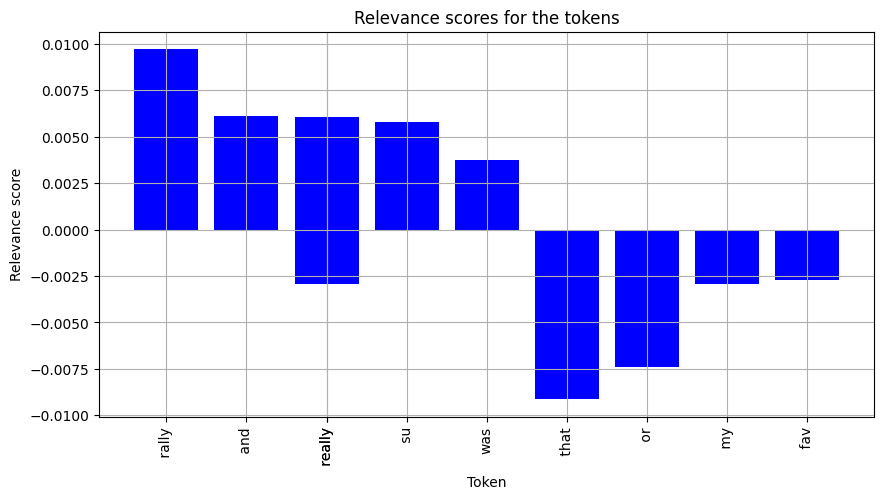

In [ ]:
import matplotlib.pyplot as plt

# plot the relevance scores

plt.figure(figsize=(10,5))
plt.bar(tokens_graph, relevance_scores_graph, color='blue')
plt.xticks(tokens_graph, tokens_graph, rotation='vertical')
plt.ylabel('Relevance score')
plt.xlabel('Token')
plt.title('Relevance scores for the tokens')
plt.grid(True)
plt.show()

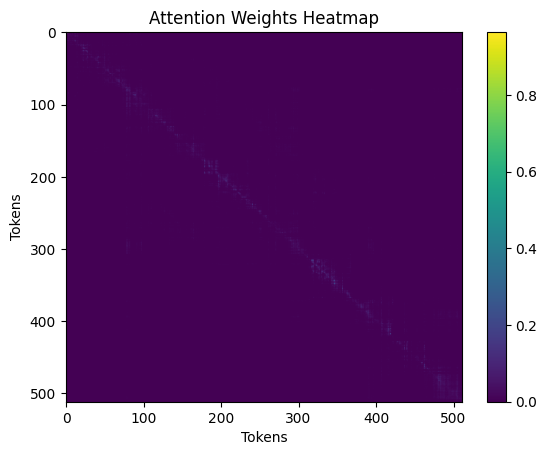

In [ ]:
plt.imshow(attentions[-1].squeeze(0)[-1].cpu().detach().numpy(), cmap='viridis', aspect='auto')
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.title("Attention Weights Heatmap")
plt.colorbar()
plt.show()